# Learning to communicate about shared procedural abstractions
## Notebook 3: Forming conventions to talk about shared abstractions

Preparation of this notebook was led by [Robert Hawkins](https://rdhawkins.com/).

These results were originally reported in: 
[McCarthy*, W., Hawkins*, R., Wang, H., Holdaway, C., and Fan, J. (2021). Learning to communicate about shared procedural abstractions. Proceedings of the 43rd Annual Meeting of the Cognitive Science Society.](https://cogtoolslab.github.io/pdf/mccarthy_cogsci_2021b.pdf)

### *NOTE: THIS NOTEBOOK SERVES AS THE "INSTRUCTOR" VERSION*

In the previous notebook we studied the problem of **concept learning**. We wanted to know how participants might have 'chunked' blocks together into larger abstractions as they proceeded through the twelve trials of the task. We worked through a model of abstraction as library learning, where people build up a collection of program fragments corresponding to possible concepts (literally 'building blocks', if you like). For each trial, we could then use the current library to propose possible programs that express the scene in different ways. 

In this notebook, we extend our model to address the **communication** problem. That is, given a tower scene and a set of concepts, what linguistic instructions should the Architect give to the Builder that will allow them to successfully reconstruct that scene? And given a set of instructions and a potentially different set of concepts, what actions should the Builder actually perform?

We approach this problem in a **probabilistic modeling** framework based on [Hawkins et al. (2023)](https://cocosci.princeton.edu/papers/hawkinspartners.pdf). 

This notebook is divided into 4 sections that incrementally build up to the full model.

**Section 1** begins by implementing the core notion of a *mental lexicon* -- a mapping from words to concepts.

**Section 2** implements basic Architect and Builder agents that make decisions based on fixed lexicons.  

**Section 3** equips these agents with the ability to *learn* and update their *beliefs* about the lexicon over time.

**Section 4** finally reaches the core theoretical question of why speakers prefer one level of abstraction over another.

## Setup 

In [27]:
import os
import sys

import functools
import itertools
import json

import pandas as pd
import numpy as np

from numpy.random import choice
from IPython.display import clear_output

In [28]:
# import classes for our model
sys.path.append("../model/convention_formation/")
from distribution import *
from lexicon import *

## Section 1: Lexicons

### Representing lexicons

The basic building block of our model is an agent's **mental lexicon**, a particular set of correspondances between concepts and words. To define an agent model, we must first define the mental lexicon. 

We have created a class for this purpose called `BlockLexicon()` which manages the mapping between program primitives (as defined in **[the previous section](https://github.com/cogtoolslab/compositional_abstractions_tutorial/blob/main/notebooks/ca_programs.ipynb)**) to words and phrases. If you're interested in digging into the nitty-gritty details, we've put this class in a helper library __[here](https://github.com/cogtoolslab/compositional_abstractions_tutorial/blob/main/model/convention_formation/lexicon.py)__).

For our purposes, though, we don't need to know exactly what's going on under the hood. Let's take the lexicon class out for a drive. We need to initialize it with two parameters, essentially corresponding to the base entities on each side of the mapping we want to define.

(1) `dsl`: a list of concepts in the domain-specific language (DSL) that might be expressed as words

(2) `lexemes`: a list of words that are available to bind to new concepts. 

To build up our intuitions, we're going to work with a very simplified example lexicon, where the set of concepts is the library on trial 10 of the trial sequence presented to one of our pairs of human participants (retrieved from the file we saved out in the previous section).

In [29]:
# Pull out the DSL primitives accessible at trial 10 for the first dyad in our empirical data
empirical_data = pd.read_json('../data/model/programs_for_you/programs_ppt_1.json')
dsl = empirical_data.iloc[10]['dsl']

We'll also define a list of lexemes, a bunch of nonsense words that won't start out meaning anything. 

In [30]:
# Define a set of meaningless placeholder words available to be bound to meanings
lexemes = ['blah', 'blab', 'bloop', 'bleep', 'floop'] 

We'll use these two ingredients to construct a `BlockLexicon` (defined [here](https://github.com/cogtoolslab/compositional_abstractions_tutorial/blob/main/model/convention_formation/lexicon.py)). 

In [31]:
l = BlockLexicon(dsl, lexemes)

The lexicon object `l` that we've created comes with a lot of handy built-in properties, including language for talking about various primitive actions of the dsl (like placing blocks). We can check these out by calling some of its functions. For example, the `dsl_to_language` method looks up which word to use for any element of the `dsl`. 

> _Note_: Function that belong to a Python class are typically called "methods" (e.g., `dsl_to_language` is a method of the `BlockLexicon` class.)

In [32]:
print('The first element in the list of DSL primitives (h) is already bound to the language "place a horizontal block."')
print(dsl[0], '->', l.dsl_to_language(dsl[0]))
print('')
print('Here are some other examples.')
print(dsl[10], '->', l.dsl_to_language(dsl[10]))
print(dsl[-1], '->', l.dsl_to_language(dsl[-1]))

The first element in the list of DSL primitives (h) is already bound to the language "place a horizontal block."
h -> place a horizontal block.

Here are some other examples.
l_8 -> move to the left by 8
chunk_C -> place a blab.


We can also go in the other direction using the `language_to_dsl` function, converting from a linguistic expression to a corresponding primitive in the DSL.
We went ahead and 'baked in' correspondences for the basic elements of our DSL, because we're assuming these meanings are pretty much deterministic; there's not much wiggle room about what 'place a horizontal block' or 'move to the left by 8' means. 

In [33]:
print('place a horizontal block. ->', l.language_to_dsl('place a horizontal block.'))
print('move to the left by 8 ->', l.language_to_dsl('move to the left by 8'))

place a horizontal block. -> h
move to the left by 8 -> l_8


> _Note_: If we wanted a more realistic model that worked on generic natural language, e.g. if we wanted to pair our agent with a real user writing in a chat box, we would want something more robust that doesn't require exact string matching. We might use a simple algorithm to find the nearest string in the lexicon, or we might use a fancier model operating over utterance embeddings.

If you play around with the `BlockLexicon()` class, you may notice a subtlety. If we pass in an unfamiliar utterance that isn't found in the list of lexemes we provided (e.g., `place a blah` shown below), it will return one of the concepts that doesn't already have a word assigned. We can think of this like an agent randomly 'guessing' rather than throwing an error. Likewise, if we pass in a concept that is not in the DSL, it will return a randomly sampled element from the list of lexemes. (If you re-run the cell below multiple times, you'll notice that the output will be different each time)

> _Note_: A more principled but complicated approach to this technical problem is to define a 'null meaning' and 'null utterance' that can be returned in these cases instead of a random guess. These 'null' objects can roughly interpreted be interpreted as "do nothing" and "say nothing".

In [34]:
print('Passing in "place a blah"...')
print('place a blah. ->', l.language_to_dsl('place a blah.'))
print('')
print('Passing in "chunk_R"...')
print('chunk_R ->', l.dsl_to_language('chunk_R'))

Passing in "place a blah"...
place a blah. -> chunk_C

Passing in "chunk_R"...
chunk_R -> bloop


### Representing beliefs about lexicons

The lexicon `l` we've been playing with so far is a deterministic data structure; it's just a single mapping. 

In a probabilistic model, however, we want to be able to talk in a mathematically rigorous way about an agent's subjective **beliefs** about a mapping. In other words, we want to be able to define a **probability distribution** over all possible lexicons $\mathcal{L}$. This will provide a precise definition for an agent's uncertainty about the lexicon in their partner's head, i.e. they assume their partner must be using one of these mappings $\mathcal{L}^*$, but do not know ahead of time exactly what it is.

We're going to introduce another custom class we've written called a `Distribution()`, which maintains the probabilities assigned to each possible lexicon. (Again, for nitty-gritty details, see the helper library __[here](https://github.com/cogtoolslab/compositional_abstractions_tutorial/blob/main/model/convention_formation/distribution.py)__). 

We'll define a **prior** distribution (the agent's initial beliefs) as a uniform distribution over all possible ways of binding elements in the DSL to the lexemes. 

In [35]:
# initializing a LexiconPrior from a specific DSL and a list of lexemes
prior = LexiconPrior(dsl, lexemes)

We've also created some handy helper functions to work with distributions. For example, `prior.support()` returns the support of the distribution `prior`, i.e. the list of values that it is defined over. So we can print out the first lexicon in the support as an example of what lexicons look like. In this case, there are 24 lexicons in the support of the prior because there are exactly 24 ways of binding the four non-primitives in the DSL (e.g., "chunk_L") to unique lexemes.

In [36]:
example_lexicon = prior.support()[0]
print('example element:', example_lexicon)

example element: {
    "h": "place a horizontal block.",
    "v": "place a vertical block.",
    "l_0": "move to the left by 0",
    "l_1": "move to the left by 1",
    "l_2": "move to the left by 2",
    "l_3": "move to the left by 3",
    "l_4": "move to the left by 4",
    "l_5": "move to the left by 5",
    "l_6": "move to the left by 6",
    "l_7": "move to the left by 7",
    "l_8": "move to the left by 8",
    "l_9": "move to the left by 9",
    "l_10": "move to the left by 10",
    "l_11": "move to the left by 11",
    "l_12": "move to the left by 12",
    "r_0": "move to the right by 0",
    "r_1": "move to the right by 1",
    "r_2": "move to the right by 2",
    "r_3": "move to the right by 3",
    "r_4": "move to the right by 4",
    "r_5": "move to the right by 5",
    "r_6": "move to the right by 6",
    "r_7": "move to the right by 7",
    "r_8": "move to the right by 8",
    "r_9": "move to the right by 9",
    "r_10": "move to the right by 10",
    "r_11": "move to the

We can also use `prior.score(l)` to return the probability of a lexicon `l` under the distribution. 

In [37]:
print(f"P(^ that lexicon) = 1/{len(prior.support())} = {prior.score(example_lexicon)}")

P(^ that lexicon) = 1/24 = 0.041666666666666664


There are a few other things you can do with a distribution object. For example, you can sample an element from the distribution with `prior.sample()`

In [38]:
print(prior.sample())

{
    "h": "place a horizontal block.",
    "v": "place a vertical block.",
    "l_0": "move to the left by 0",
    "l_1": "move to the left by 1",
    "l_2": "move to the left by 2",
    "l_3": "move to the left by 3",
    "l_4": "move to the left by 4",
    "l_5": "move to the left by 5",
    "l_6": "move to the left by 6",
    "l_7": "move to the left by 7",
    "l_8": "move to the left by 8",
    "l_9": "move to the left by 9",
    "l_10": "move to the left by 10",
    "l_11": "move to the left by 11",
    "l_12": "move to the left by 12",
    "r_0": "move to the right by 0",
    "r_1": "move to the right by 1",
    "r_2": "move to the right by 2",
    "r_3": "move to the right by 3",
    "r_4": "move to the right by 4",
    "r_5": "move to the right by 5",
    "r_6": "move to the right by 6",
    "r_7": "move to the right by 7",
    "r_8": "move to the right by 8",
    "r_9": "move to the right by 9",
    "r_10": "move to the right by 10",
    "r_11": "move to the right by 11",
  

And we can use the `marginalize` function to collapse down to the mapping for a single dsl or language element.

In [39]:
print('possible utterances for chunk_L : ', 
      prior.marginalize(lambda l : l.dsl_to_language('chunk_L')))

print('possible concepts for "place a blah" : ', 
      prior.marginalize(lambda l : l.language_to_dsl('place a blah.')))

possible utterances for chunk_L :  {
    "place a blab.": 0.24999999999999997,
    "place a bloop.": 0.24999999999999997,
    "place a bleep.": 0.24999999999999997,
    "place a blah.": 0.24999999999999997
}
possible concepts for "place a blah" :  {
    "chunk_C": 0.24999999999999997,
    "chunk_L": 0.24999999999999997,
    "chunk_Pi": 0.24999999999999997,
    "chunk_8": 0.24999999999999997
}


Here, we can verify that the novel element 'chunk_L' in the DSL is initially equally likely to be mapped to any of the novel lexemes: $p = 1/|U|$. The equal probabilities for each expression tell us that the Agents think each expression is an equally good (or bad) translation of "chunk_L".

> _Note:_  A uniform prior makes sense for this artificial language (where "bleeps" and "bloops" are used to refer to abstractions). Real people likely have strong priors about what words will mean (we can make quite a lot of sense of "build an L" before any shared experience, even if there's some remaining uncertainty about properties of the L like its size and width, etc). But a uniform prior helps us understand the dynamics of coordination in the most extreme case. 

## Section 2: Simulating Agents

Now we have a way of representing an agent's beliefs over lexicons, we can define an Architect and Builder.

Both maintain their own belief distribution about the *other agent's* lexicon.

The **Architect** agent makes choices about what to say based by imaginging how the Builder will interpret them.  

The **Builder** takes actions based on its beliefs about what the Architect would say in different situations. 

In [40]:
class FixedAgent() :
    def __init__(self, role, trial) :
        '''
        Args: 
           * role: string giving agent's role in the task ('architect' or 'builder')
           * trial: dictionary of meta-data about the current trial 
        '''

        # initialize beliefs to a uniform prior over possible lexicons, as above
        self.beliefs = LexiconPrior(trial['dsl'], lexemes)

        # set other useful properties
        self.role = role
        self.actions = trial['dsl']
        self.utterances = self.beliefs.sample().utterances
        
    def act(self, observation) :
        '''
        produce an action based on role and current beliefs
        '''
        if self.role == 'architect' :
            # Architect is going to build up a distribution over utterances to say
            utt_dist = self.beliefs.marginalize(lambda l : l.dsl_to_language(observation))
            return utt_dist.sample()

        if self.role == 'builder' :
            # get P(a | utt) by marginalizing over lexicons 
            action_dist = self.beliefs.marginalize(lambda l : l.language_to_dsl(observation))
            return action_dist.sample()

Because our focus is on modeling abstractions learned during the task, we assume that Architect Agents and Builder Agents can unambiguously communicate about the base DSL-- moving left and right and placing individual blocks. I.e. when an Architect wants a Builder to place a block they will always say "place a horizontal block", and the Builder will correctly interpret this utterance.

The only thing that varies across different lexicons is the words used for *learned* program fragments. In practice (for this example) only five of these were learned across all participants' trial sequences. The set of possible lexicons is therefore fully defined by the set of possible mappings from these fragments to the `lexemes` defined above.

For the built-in primitives like the horizontal block, this should be a deterministic choice:

In [41]:
first_trial = empirical_data.iloc[0].to_dict()
architect = FixedAgent('architect', first_trial)
print('architect utterance: `h` -> ', architect.act('h'))

builder = FixedAgent('builder', first_trial)
print('builder choice: "place a horizontal block" -> ', builder.act('place a horizontal block.'))

architect utterance: `h` ->  place a horizontal block.
builder choice: "place a horizontal block" ->  h


### Running simulations

Now we have our agents, let's see what they do when they proceed through the same sequence of 12 trials as one human dyad from our behavioral experiment.

On each trial, the (Fixed) Architect will see a tower scene and then write a program in their DSL that could re-generate the scene. Then for each `step` of the program, we call `architect.act(step)` to get a corresponding linguistic instruction (`utt`, for utterance). We then pass that instruction (`utt`) to the builder agent who will select an action in their own DSL using the function `builder.act(utt)`. 

In [42]:
def run_simulation(trial_info) :
    output = SimulationOutput()
    for i, trial in trial_info.iterrows() :
        # Initialize agents using current trial metadata
        architect = FixedAgent('architect', trial)
        builder = FixedAgent('builder', trial)

        # if there are multiple program representations, randomly 
        # select which one to comunicate (we will return to this)
        target_program = choice(list(trial['programs_with_length'].keys()))

        # loop through steps of target program one at a time
        # produce an utterance from architect and response from builder
        for step in target_program.split(' ') :
            utt = architect.act(step)
            response = builder.act(utt)
            output.save(step, utt, response) 

        # flush output buffer and prepare for next trial
        output.flush(trial, target_program)
    return output.get_df()

In [43]:
# we can call the run_simulation function above to simulate the utterances and actions that would be generated 
# in a 12-trial interaction between the Architect and Builder. Note that if you run it multiple times, you'll get 
# different simulated outcomes each time. 
run_0 = run_simulation(empirical_data)
display(run_0)

,trial,utterance,response,intention,target_program,dsl,target_length,acc
0,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
1,1.0,move to the left by 4,l_4,l_4,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
2,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
3,1.0,move to the left by 1,l_1,l_1,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
4,1.0,place a vertical block.,v,v,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
...,...,...,...,...,...,...,...,...
6,11.0,move to the right by 1,r_1,r_1,chunk_Pi r_7 h l_1 v v r_1 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0
7,11.0,place a horizontal block.,h,h,chunk_Pi r_7 h l_1 v v r_1 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0
0,12.0,place a bleep.,chunk_L,chunk_Pi,chunk_Pi r_9 chunk_L,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",3.0,0.0
1,12.0,move to the right by 9,r_9,r_9,chunk_Pi r_9 chunk_L,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",3.0,1.0


In [44]:
# let's inspect the first trial
print('target program: \n', run_0.query('trial==1').loc[0,'target_program'])
run_0.query('trial==1')[['utterance','intention','response','acc']]

target program: 
 h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h


,utterance,intention,response,acc
0,place a horizontal block.,h,h,1.0
1,move to the left by 4,l_4,l_4,1.0
2,place a horizontal block.,h,h,1.0
3,move to the left by 1,l_1,l_1,1.0
4,place a vertical block.,v,v,1.0
5,place a vertical block.,v,v,1.0
6,move to the right by 9,r_9,r_9,1.0
7,place a vertical block.,v,v,1.0
8,move to the right by 6,r_6,r_6,1.0
9,place a vertical block.,v,v,1.0


In [45]:
# let's inspect the final trial
print('target program: \n', run_0.query('trial==12').loc[0,'target_program'])
run_0.query('trial==12')[['utterance','intention','response','acc']]

target program: 
 chunk_Pi r_9 chunk_L


,utterance,intention,response,acc
0,place a bleep.,chunk_Pi,chunk_L,0.0
1,move to the right by 9,r_9,r_9,1.0
2,place a blah.,chunk_L,chunk_L,1.0


Notice that the final trial may use some chunks, but their correspondence to utterances have not changed between the first and final trials. That is because these are "fixed" agents who do not yet have a way of updating their lexicons!

### <span style="color: orange"> Exercise: explore how accuracy changes </span>

If they do use chunks, you might notice that the accuracy gets worse over time because our agents aren't actually *learning* -- they're continuing to use their initial uniform priors. We can take a look at this by analyzing how accuracy (`acc`) changes across trials in the `run_0` dataframe.

In [46]:
### CODE BLOCK FOR EXERCISE


In [47]:
# summarize accuracy by trial for fixed agents
fixed_acc_by_trial = (run_0
                      .groupby("trial", as_index=False)["acc"]
                      .mean()
                      .rename(columns={"acc": "mean_acc"}))

fixed_acc_by_trial


,trial,mean_acc
0,1.0,1.000000
1,2.0,1.000000
2,3.0,1.000000
3,4.0,1.000000
4,5.0,1.000000
5,6.0,1.000000
6,7.0,0.875000
7,8.0,1.000000
8,9.0,0.888889
9,10.0,0.333333


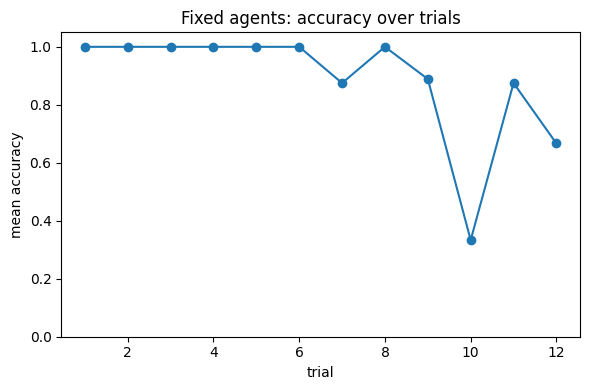

In [48]:
# visualize accuracy over trials for fixed agents
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(fixed_acc_by_trial["trial"], fixed_acc_by_trial["mean_acc"], marker="o")
plt.xlabel("trial")
plt.ylabel("mean accuracy")
plt.ylim(0.0, 1.05)
plt.title("Fixed agents: accuracy over trials")
plt.tight_layout()

## Section 3: Simulating learning

In a probabilistic framework, learning is equivalent to updating one's beliefs given new observations. We thus need to extend our `FixedAgent` class from Section 2 with a `update_beliefs()` function, using Bayes' rule to turn their prior into a posterior, $P(\mathcal{L} | o)$, using the outcomes `o` on the previous trials. Here's Bayes' rule, which gives us a blueprint to handle this:

$$P(\mathcal{L} | o) = \frac{P(o | \mathcal{L})P(\mathcal{L})}{\sum_{\mathcal{L}} P(o | \mathcal{L}) P(\mathcal{L})}$$

We already have the prior term $P(\mathcal{L})$, but we're missing the likelihood term $P(o | \mathcal{L})$ which scores how likely a given utterance or action on the previous trials would be under different lexicons $\mathcal{L}$. 

Following Hawkins et al. (2023), we use a likelihood where each agent reasons about a (simplified) mental model of the other agent, and asks how likely the other agent would be to make a given choice if they had a given lexicon in their head. Specifically, the architect tries to design utterances to maximize the probability of success assuming a literal builder $B_0(a | u)$, which chooses among actions $a$ that are literally consistent with the utterance $u$ they hear. Meanwhile, the builder tries to pick actions assuming the architect $A_0(u | a^*)$ is choosing utterances $u$ that are literally consistent with the target step $a^*$ they are trying to convey.

In [49]:
class LearningAgent(FixedAgent) :
    def __init__(self, role, curr_trial, previous_trials) :
        super().__init__(role, curr_trial)
        combined_primitives = (set().union(curr_trial['dsl'], *previous_trials['dsl']) 
                                if not previous_trials.empty else self.actions)

        # Initialize beliefs to uniform prior and then compute 
        self.prior = LexiconPrior(combined_primitives, lexemes)
        self.update_beliefs(previous_trials)

    def B0(self, utterance, lexicon) :
        '''
        simple builder agent that has equal probability
        of building anything that's literally consistent with the utterance
        '''
        builder_dist = EmptyDistribution()
        for action in self.actions :
            builder_dist.update({action : 1 if action == lexicon.language_to_dsl(utterance) else 0.01})
        builder_dist.renormalize()
        return builder_dist
        
    def A0(self, intention, lexicon) :
        '''
        simple architect agent that has equal probability
        of saying anything that's literally consistent with the intention
        '''
        architect_dist = EmptyDistribution()
        for utt in self.utterances :
            architect_dist.update({utt : 1 if utt == lexicon.dsl_to_language(intention) else 0.01})
        architect_dist.renormalize()
        return architect_dist

    def update_beliefs(self, previous_trial_df) :
        '''
        run bayes rule given observations in previous trials
        note that we run the calculation in log space because it's more numerically stable
        '''
        posterior = EmptyDistribution()
        posterior.to_logspace()

        # we're manually doing the calculation in Bayes Rule
        # P(l | obs) \propto P(l) * \prod_{o \in obs} P(o | l)
        # ==> log P(l|obs) \propto log P(l) + \sum_{o \in obs} log P(o | l)
        for lexicon in self.prior.support() :
            # calculate the likelihood of the previous data under each lexicon, 
            likelihood_term = 0
            for i, step in previous_trial_df.iterrows() :
                if self.role == 'architect' :
                    likelihood_term += np.log(self.B0(step.utterance, lexicon).score(step.response))
                elif self.role == 'builder' :
                    likelihood_term += np.log(self.A0(step.intention, lexicon).score(step.utterance))
            
            # weight by the prior probability of that lexicon
            prior_term = np.log(self.prior.score(lexicon))
            posterior.update({lexicon : prior_term + likelihood_term})

        # Renormalize (this is the \propto part of Bayes Rule, the denominator)
        posterior.renormalize()
        posterior.from_logspace()
        self.beliefs = posterior

Take a moment to inspect the `LearningAgent` class definition above. In particular, pay special attention to the `update_beliefs()` function which performs the heavy lifting to actually update each agent's beliefs based on what they have observed so far (`previous_trial_df`). 


In [50]:
def run_learning_simulation(trial_info, verbose = False) :
    output = SimulationOutput()
    for i, current_trial in trial_info.iterrows() :
        clear_output(wait=True)
        print(f'trial {i}/12')
        
        # construct agents with updated beliefs up to this point
        previous_trials = output.get_df()
        architect = LearningAgent('architect', current_trial, previous_trials)
        builder = LearningAgent('builder', current_trial, previous_trials) 

        # random program selected from the options
        target_program = choice(list(current_trial['programs_with_length'].keys()))

        # loop through steps of target program one at a time
        for step in target_program.split(' ') :
            utt = architect.act(step)
            response = builder.act(utt)
            output.save(step, utt, response) 
        
        output.flush(current_trial, target_program)
    return output.get_df()

In [51]:
learning_run_0 = run_learning_simulation(empirical_data, verbose = True)
learning_run_0

trial 11/12


,trial,utterance,response,intention,target_program,dsl,target_length,acc
0,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
1,1.0,move to the left by 4,l_4,l_4,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
2,1.0,place a horizontal block.,h,h,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
3,1.0,move to the left by 1,l_1,l_1,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
4,1.0,place a vertical block.,v,v,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",14.0,1.0
...,...,...,...,...,...,...,...,...
3,12.0,move to the left by 4,l_4,l_4,chunk_Pi r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0
4,12.0,place a horizontal block.,h,h,chunk_Pi r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0
5,12.0,move to the left by 1,l_1,l_1,chunk_Pi r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0
6,12.0,place a vertical block.,v,v,chunk_Pi r_9 h l_4 h l_1 v v,"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",8.0,1.0


## Section 4: Choosing programs.

In principle, words allow us to communicate arbitrarily complex concepts, and our mental representation of linguistic meaning is flexible enough to be updated over time. To the extent that both Architects and Builders are learning to 'chunk' blocks over time, each  program fragment) could, in principle, be assigned a new word or phrase, and conveyed directly through the Architects' instructions. Well, almost. There is no guarantee that the words the Architect chooses to pick out a new concept would invoke the same concept in someone else. There is actually uncertainty about how the Builder will interpret the Architects' instructions and this, we suggest, might change what the Architect chooses to say.

Our hypothesis is that Architects trade-off communicative *efficiency* with communicative *effectiveness*. While they generally want to say things concisely, if there is too much uncertainty about how the Builder will interpret their words, they will choose a less ambiguous (if more verbose) way of expressing the same information. Concretely, if the Architect wanted to say "build an L" but they thought that the Builder wouldn't get what "L" meant, they might spell out the steps to make an L-shaped tower instead.

Wow, this is great! We can see our agents are updating their beliefs about the lexicon over time and able to get somewhat more accurate as they coordinate. But one of the most interesting things about our empirical data is that speakers seem to be strategically choosing which representation of the tower to convey -- our hypothesis is that the reason participants reduce the length of their utterances over time is that even when new library chunks come online, architects don't always try to refer to them right away. They aren't confident enough that their partner will understand, as the block-level descriptions are much safer. However, the block-level descriptions are also much *costlier* in terms of time and effect because they have to laboriously describe one action at a time. 

So far, we just used a placeholder for how the speaker picks which representation to communication: they just randomly pick from the list of candidates, slightly preferring shorter programs. However, there are other considerations that ought to go into this decision, namely the estimated likelihood that the listener will do the right thing.

In [52]:
from scipy.special import softmax

class StrategicArchitect(LearningAgent) :
    def __init__(self, curr_trial, previous_trials) :
        super().__init__('architect', curr_trial, previous_trials) 
        self.alpha = 2
        self.beta = .3

    def expected_inf(self, utterance, intention) :
        '''
        computes the expected utility of transmitting the given intention with utterance
        accounting for uncertainty of whether utterance will work
        '''
            # calculate expected inf(u) = \sum_a*\in A* \sum_L P(L) * ln P_B(a* | u, L) 
        return sum([
            self.beliefs.score(l) * np.log(self.B0(utterance, l).score(intention))
            for l in self.beliefs.support()
        ])
        
    def speak(self, possible_programs) :
        '''
        produce an action based on role and current beliefs
        '''
        # Architect is going to build up a distribution over utterances to say
        # Architect selects which program representation to comunicate proportional to informativity and length
        p_utils = []
        for target_program in possible_programs: 
            step_utils = []
            for step in target_program.split(' ') :
                utt_utils = np.array([self.expected_inf(utt, step) for utt in self.utterances])
                step_utils.append(sum(utt_utils * softmax(self.alpha * utt_utils)))
            p_utils.append(   
                (1 - self.beta) * np.mean(step_utils) 
              - (    self.beta) * len(target_program.split(' '))
            )
            print(p_utils)
        # sample a program
        chosen_p = choice(a = possible_programs, p = softmax(self.alpha * np.array(p_utils)))
        # sample utterances for that program
        return chosen_p, [self.act(step) for step in chosen_p.split(' ')]

def run_strategic_simulation(empirical_data) :
    output = SimulationOutput()
    for i, current_trial in empirical_data.iterrows() :
        previous_trials = output.get_df()
        architect = StrategicArchitect(current_trial, previous_trials)
        builder = LearningAgent('builder', current_trial, previous_trials)

        # Jointly pick a program to communicate, and what to say
        possible_programs = list(current_trial['programs_with_length'].keys())
        chosen_program, utt_seq = architect.speak(possible_programs)
        print(f'trial: {i}, chosen program: {chosen_program}')

        # loop through steps of target program one at a time
        for intention, utt in zip(chosen_program.split(' '), utt_seq) :
            response = builder.act(utt)
            output.save(intention, utt, response)
            
        output.flush(current_trial, chosen_program)
    return output.get_df()

print(run_strategic_simulation(empirical_data))

[-4.375992165077049]
trial: 0, chosen program: h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
[-4.075992165077048]
trial: 1, chosen program: h l_4 h l_1 v v r_12 h l_1 v v r_1 h
[-4.375992165077049]
trial: 2, chosen program: h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
[-3.4818029855099226]
[-3.4818029855099226, -4.381802985509923]
trial: 3, chosen program: v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h
[-2.296923153998044]
[-2.296923153998044, -4.0875710160956835]
trial: 4, chosen program: chunk_8b r_1 h r_12 h l_4 chunk_8b
[-2.0018134531430185]
[-2.0018134531430185, -3.180233993703332]
[-2.0018134531430185, -3.180233993703332, -2.622576320284631]
[-2.0018134531430185, -3.180233993703332, -2.622576320284631, -4.399805439012713]
trial: 5, chosen program: chunk_Pi r_9 chunk_L
[-2.4872732522152603]
[-2.4872732522152603, -2.8602166078968123]
[-2.4872732522152603, -2.8602166078968123, -2.860216607896812]
[-2.4872732522152603, -2.8602166078968123, -2.860216607896812, -4.100126613054093]
trial: 6, chosen progra

### Summary


Congratulations! You've finished the tutorial!

We hope you found it fun and informative. :D

In [53]:
# summarize accuracy by trial for learning agents
learning_acc_by_trial = (learning_run_0
                         .groupby("trial", as_index=False)["acc"]
                         .mean()
                         .rename(columns={"acc": "mean_acc"}))

learning_acc_by_trial


,trial,mean_acc
0,1.0,1.000000
1,2.0,1.000000
2,3.0,1.000000
3,4.0,1.000000
4,5.0,1.000000
5,6.0,1.000000
6,7.0,1.000000
7,8.0,0.666667
8,9.0,1.000000
9,10.0,0.875000


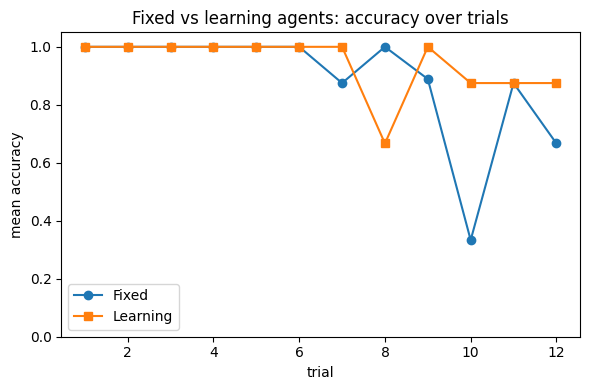

In [54]:

# compare fixed vs learning agents: accuracy over trials
plt.figure(figsize=(6, 4))
plt.plot(fixed_acc_by_trial["trial"],
         fixed_acc_by_trial["mean_acc"],
         marker="o",
         label="Fixed")
plt.plot(learning_acc_by_trial["trial"],
         learning_acc_by_trial["mean_acc"],
         marker="s",
         label="Learning")
plt.xlabel("trial")
plt.ylabel("mean accuracy")
plt.ylim(0.0, 1.05)
plt.title("Fixed vs learning agents: accuracy over trials")
plt.legend()
plt.tight_layout()
